## Image In-painting with OpenVINO™
This notebook demonstrates how to use an image in-painting model with OpenVINO, using [GMCNN model](https://github.com/shepnerd/inpainting_gmcnn) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). This model, given a tampered image, is able to create something very similar to the original image. The Following pipeline will be used in this notebook.
![pipeline](https://user-images.githubusercontent.com/4547501/165792473-ba784c0d-0a37-409f-a5f6-bb1849c1d140.png)


In [1]:
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from openvino.runtime import Core, Tensor
from IPython.display import Markdown, display

sys.path.append("../utils")
import notebook_utils as utils

### Download the Model
Download `gmcnn-places2-tf`model (this step will be skipped if the model is already downloaded) and then unzip it. Downloaded model stored in TensorFlow frozen graph format. The steps how this frozen graph can be obtained from original model checkpoint can be found in this [instruction](https://docs.openvino.ai/2023.0/omz_models_model_gmcnn_places2_tf.html#steps-to-reproduce-conversion-to-frozen-graph)


In [2]:
# A directory where the model will be downloaded.
base_model_dir = "model"
# The name of the model from Open Model Zoo.
model_name = "gmcnn-places2-tf"

model_path = Path(f"{base_model_dir}/public/{model_name}/frozen_model.pb")
if not model_path.exists():
    model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/gmcnn-places2-tf/{model_name}.zip"
    utils.download_file(model_url, model_name, base_model_dir)
else:
    print("Already downloaded")

with ZipFile(f'{base_model_dir}/{model_name}' + '', "r") as zip_ref:
    zip_ref.extractall(path=Path(base_model_dir, 'public', ))

Already downloaded


### Convert Tensorflow model to OpenVINO IR format

The pre-trained model is in TensorFlow format. To use it with OpenVINO, convert it to OpenVINO IR format. To do this Model Optimizer is used. For more information about Model Optimizer, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). This step is also skipped if the model is already converted.


In [3]:
model_dir = Path(base_model_dir, 'public', 'ir')
ir_path = Path(f"{model_dir}/frozen_model.xml")

# Run Model Optimizer to convert model to OpenVINO IR FP32 format, if the IR file does not exist.
if not ir_path.exists():
    mo_command = f'mo --input_model {model_path} --input Placeholder,Placeholder_1 --input_shape [1,512,680,3],[1,512,680,1] --output=Minimum --output_dir {model_dir}'
    display(Markdown(f"Model Optimizer command to convert the Tensorflow model to IR: `{mo_command}`"))
    display(Markdown("_Converting model to IR. This may take a few minutes..._"))
    ! $mo_command
else:
    print(f"{ir_path} already exists.")

model/public/ir/frozen_model.xml already exists.


### Load the model

Now, load the OpenVINO IR model and perform as follows:

 1. Initialize OpenVINO Runtime (Core).
 2. Read the network from `*.bin` and `*.xml` files (weights and architecture)
 3. Compile the model for the "CPU".
 4. Get input and output nodes.

Only a few lines of code are required to run the model:

In [4]:
core = Core()

# Read the model.xml and weights file
model = core.read_model(model=ir_path)
# Load the model on to the CPU
compiled_model = core.compile_model(model=model, device_name="CPU")
# Store the input and output nodes
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

### Determine the input shapes of the model

Note that both input shapes are the same. However, the second input has 1 channel (monotone).

In [5]:
N, H, W, C = input_layer.shape

### Create a square mask

Next, create a single channeled mask that will be laid on top of the original image.

In [6]:
def create_mask(image_width, image_height, size_x=30, size_y=30, number=1):
    """
    Create a square mask of defined size on a random location.

    :param: image_width: width of the image
    :param: image_height: height of the image
    :param: size: size in pixels of one side
    :returns:
            mask: grayscale float32 mask of size shaped [image_height, image_width, 1]
    """

    mask = np.zeros((image_height, image_width, 1), dtype=np.float32)
    for _ in range(number):
        start_x = np.random.randint(image_width - size_x)
        start_y = np.random.randint(image_height - size_y)
        cv2.rectangle(img=mask,
                      pt1=(start_x, start_y),
                      pt2=(start_x + size_x, start_y + size_y),
                      color=(1, 1, 1),
                      thickness=cv2.FILLED)
    return mask

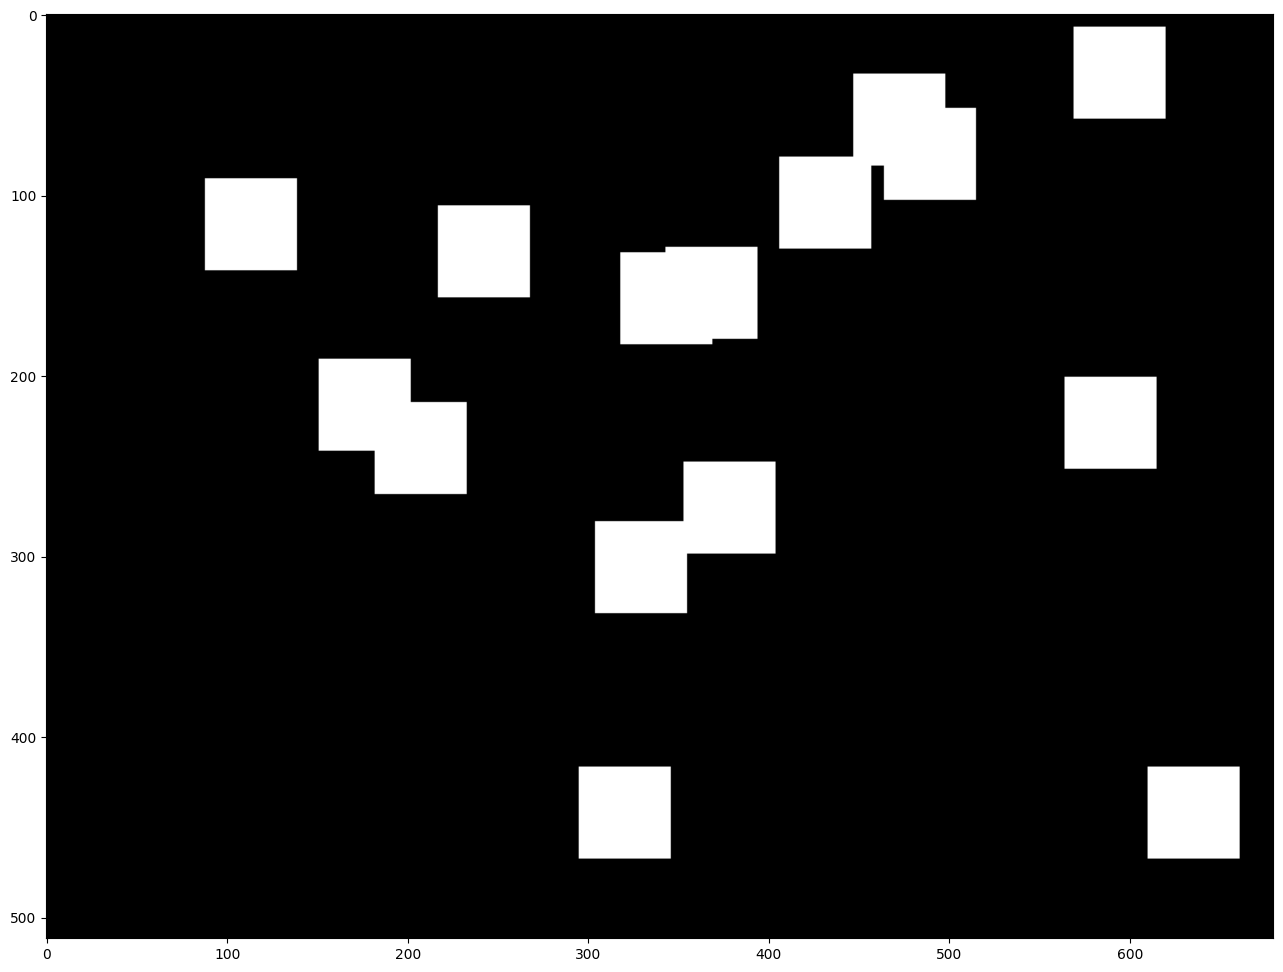

In [7]:
# Generate a square mask of size WxH with number of "holes".
mask = create_mask(image_width=W, image_height=H, size_x=50, size_y=50, number=15)
# This mask will be laid over the input image as noise.
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB));

### Load and Resize the Image

This image will be altered by using the mask. You can process any image you like. Just change the URL below.

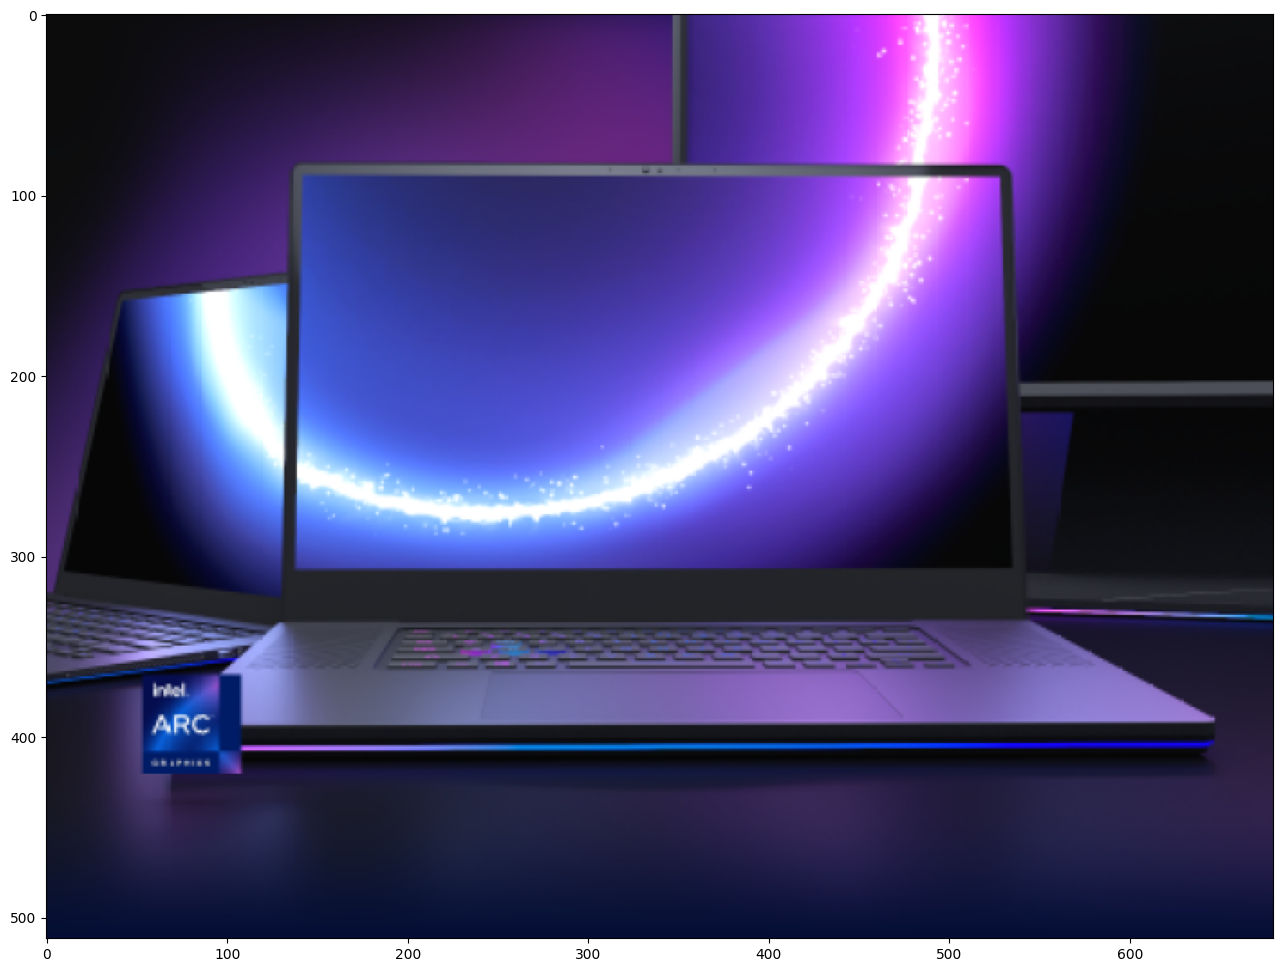

In [8]:
img_path = Path("data/laptop.png")

if not img_path.exists():
    # Download an image.
    url = "https://www.intel.com/content/dam/www/central-libraries/us/en/images/arc-home-hero-128.png.rendition.intel.web.480.360.png"
    image_file = utils.download_file(
        url, filename="laptop.png", directory="data", show_progress=False, silent=True, timeout=30
    )

# Read the image.
image = cv2.imread(str(img_path))
# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(src=image, dsize=(W, H), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB));

### Generating the Masked Image

This multiplication of the image and the mask gives the result of the masked image layered on top of the original image. The `masked_image` will be the first input to the GMCNN model.

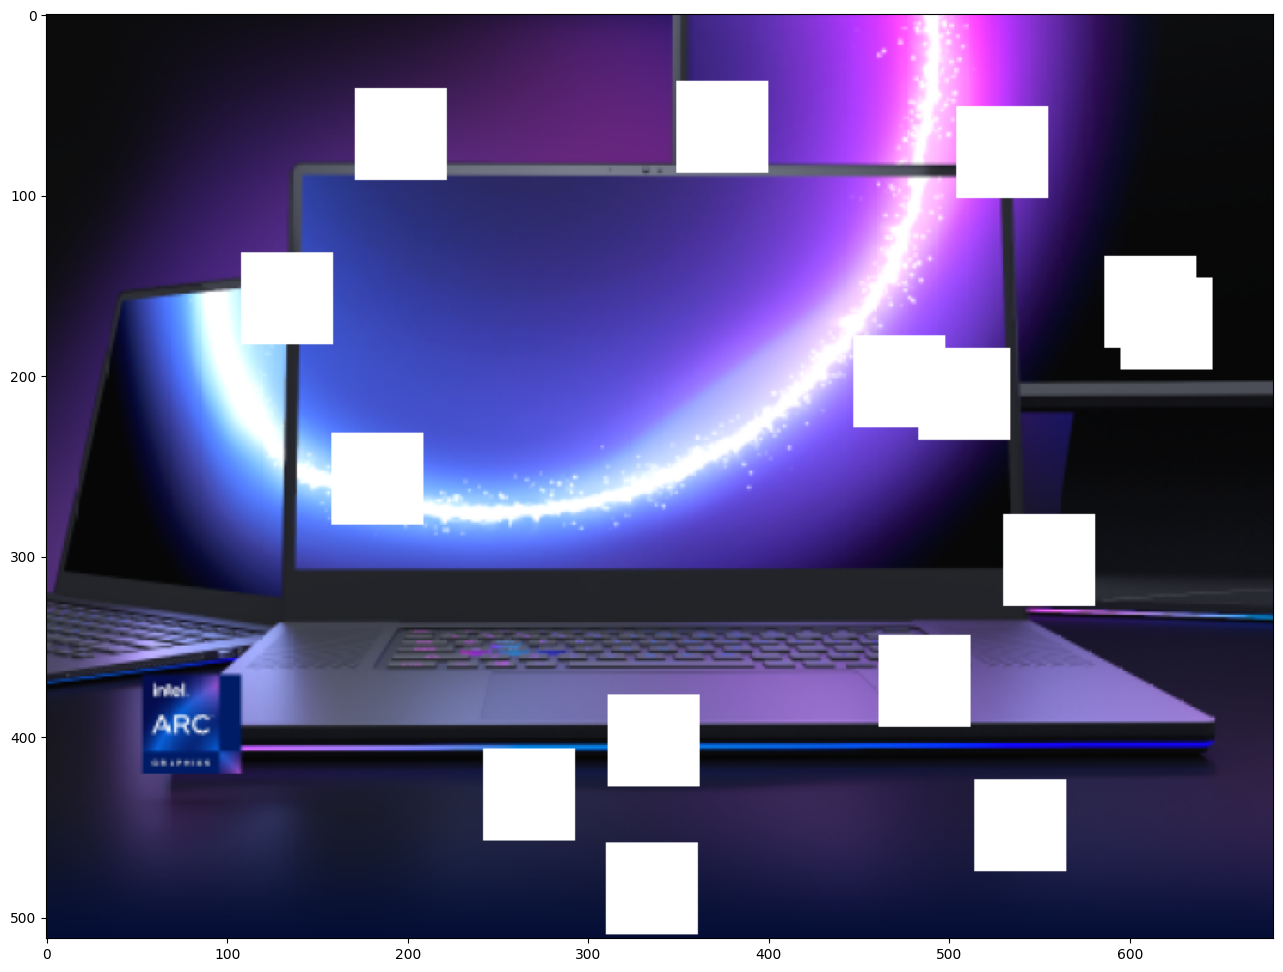

In [9]:
# Generating a masked image.
masked_image = (resized_image * (1 - mask) + 255 * mask).astype(np.uint8)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB));

### Preprocessing

The model expects the input dimensions to be `NHWC`.

- masked_image.shape = (512,680,3) -----> model expects = (1,512,680,3)
- resized_mask.shape = (512,680,1) -----> model expects = (1,512,680,1)

In [10]:
masked_image = masked_image[None, ...]
mask = mask[None, ...]

### Inference

Do inference with the given masked image and the mask. Then, show the restored image.

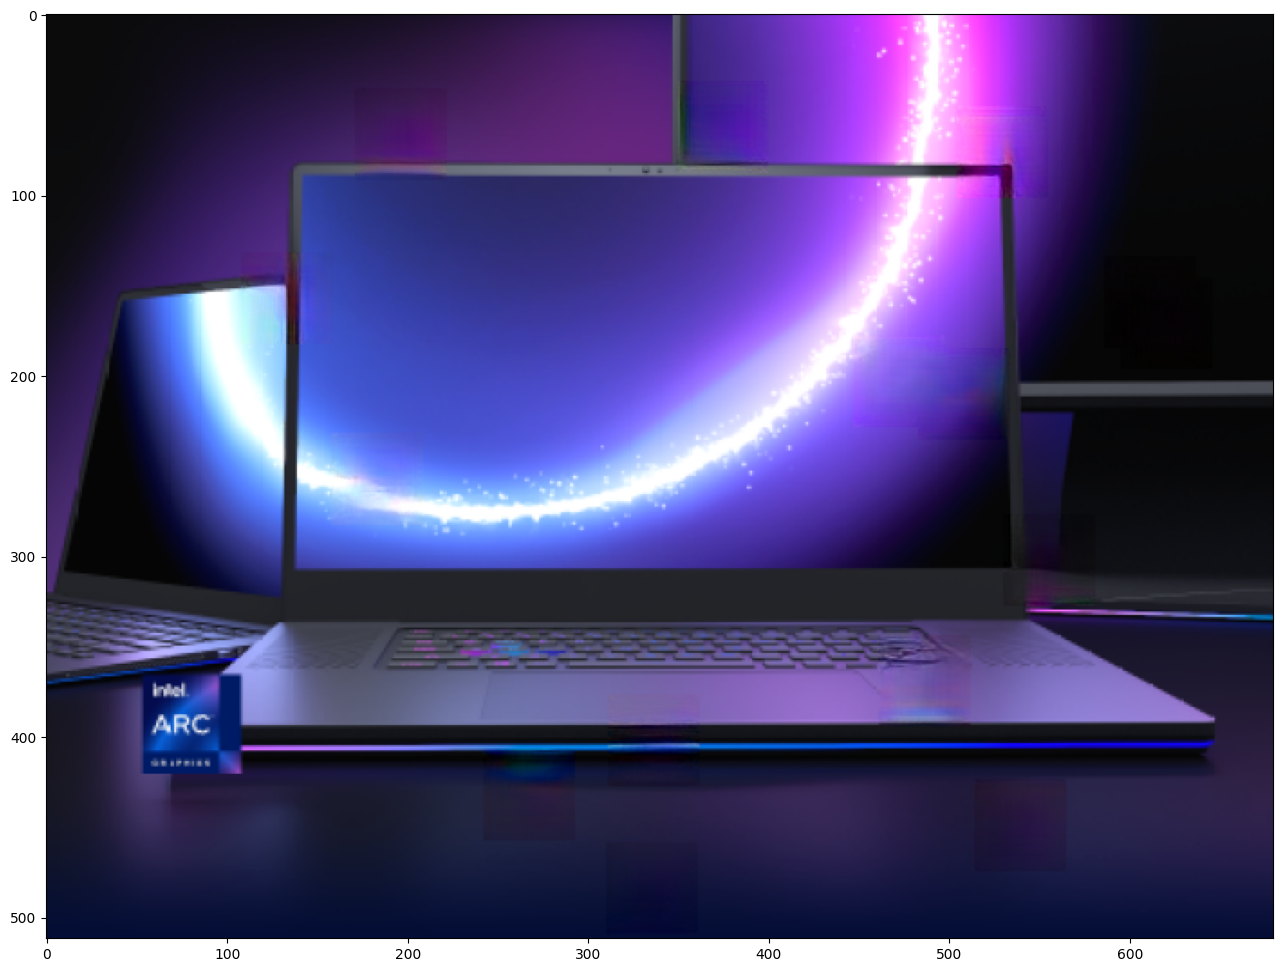

In [11]:
from openvino.runtime import Tensor

result = compiled_model([Tensor(masked_image.astype(np.float32)), Tensor(mask.astype(np.float32))])[output_layer]
result = result.squeeze().astype(np.uint8)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

### Save the Restored Image

Save the restored image to the data directory to download it.

In [12]:
cv2.imwrite("data/laptop_restored.png", result);

True